In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [2]:
parent_directory = ("drive/MyDrive/Colab Notebooks/Birds")

In [3]:
X = []
y = []

In [4]:
for i, subfolder in enumerate(os.listdir(parent_directory)):
  full_directory = os.path.join(parent_directory, subfolder)
  for file in os.listdir(full_directory):
    full_path = os.path.join(full_directory, file)
    image = cv2.imread(full_path)
    image = cv2.resize(image,(224, 224))
    X.append(image)
    y.append(i)

In [5]:
X =np.array(X)
y =np.array(y)
X.shape

(1763, 224, 224, 3)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

In [7]:
X_train = X_train.astype('float32') / 255.0
X_test= X_test.astype('float32') / 255

In [8]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:],padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(2, 2,padding='same'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

initial_lr = 0.001
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [11]:
# Learning Rate Schedule
def lr_scheduler(epoch, lr):
    return lr * 0.95

lr_schedule = LearningRateScheduler(lr_scheduler)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Train the model
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=10),
                    validation_data=(X_test, y_test_encoded),
                    epochs=100,
                    callbacks=[lr_schedule, early_stopping])

Epoch 1/100
150/150 [==============================] - 428s 3s/step - loss: 2.3386 - accuracy: 0.1268 - val_loss: 2.1369 - val_accuracy: 0.1774 - lr: 9.0250e-04
Epoch 2/100
150/150 [==============================] - 401s 3s/step - loss: 2.0303 - accuracy: 0.2644 - val_loss: 1.8283 - val_accuracy: 0.3472 - lr: 8.5737e-04
Epoch 3/100
150/150 [==============================] - 401s 3s/step - loss: 1.8180 - accuracy: 0.3585 - val_loss: 1.5733 - val_accuracy: 0.4679 - lr: 8.1451e-04
Epoch 4/100
150/150 [==============================] - 396s 3s/step - loss: 1.5921 - accuracy: 0.4406 - val_loss: 1.2781 - val_accuracy: 0.5245 - lr: 7.7378e-04
Epoch 5/100
150/150 [==============================] - 400s 3s/step - loss: 1.5340 - accuracy: 0.4646 - val_loss: 1.2120 - val_accuracy: 0.5623 - lr: 7.3509e-04
Epoch 6/100
150/150 [==============================] - 400s 3s/step - loss: 1.3852 - accuracy: 0.5381 - val_loss: 1.5524 - val_accuracy: 0.4717 - lr: 6.9834e-04
Epoch 7/100
150/150 [=============

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

9/9 [==============================] - 16s 2s/step - loss: 0.7891 - accuracy: 0.7660
Test Loss: 0.7891131639480591, Test Accuracy: 0.7660377621650696


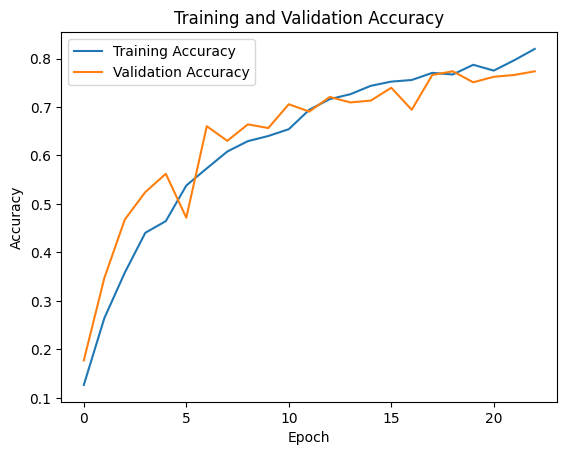

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
class_indices = {i: class_name for i, class_name in enumerate(os.listdir(parent_directory))}
print("Class Indices:", class_indices)

Class Indices: {0: 'ABBOTTS BABBLER', 1: 'ABYSSINIAN GROUND HORNBILL', 2: 'ALBATROSS', 3: 'AFRICAN EMERALD CUCKOO', 4: 'AFRICAN PYGMY GOOSE', 5: 'AFRICAN OYSTER CATCHER', 6: 'ABBOTTS BOOBY', 7: 'AFRICAN PIED HORNBILL', 8: 'AFRICAN FIREFINCH', 9: 'AFRICAN CROWNED CRANE', 10: 'ALBERTS TOWHEE'}


In [21]:
# Load and preprocess the test images
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [23]:
from matplotlib.ticker import MaxNLocator

def visualize_predictions(model, class_indices, image_paths, actual_classes):
    predictions_list = []

    for image_path, actual_class in zip(image_paths, actual_classes):
        test_image = load_and_preprocess_image(image_path)
        if test_image is None:
            continue

        predictions = model.predict(test_image)
        predicted_class_index = np.argmax(predictions)
        predicted_class_name = class_indices[predicted_class_index]
        predictions_list.append(predicted_class_name)

        # Display the image along with actual and predicted classes
        img = cv2.imread(image_path)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class_name}')
        plt.show()

    return predictions_list

1/1 [==============================] - 0s 124ms/step


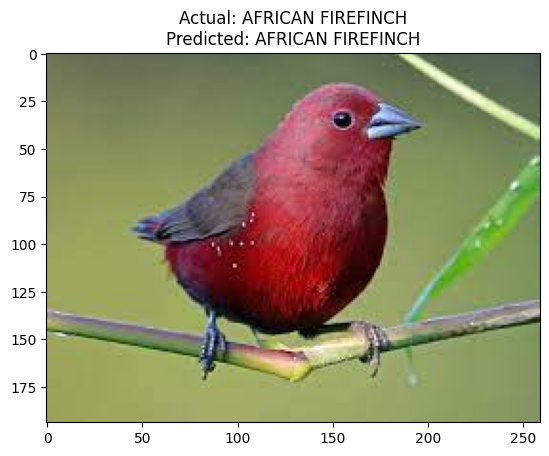

1/1 [==============================] - 0s 139ms/step


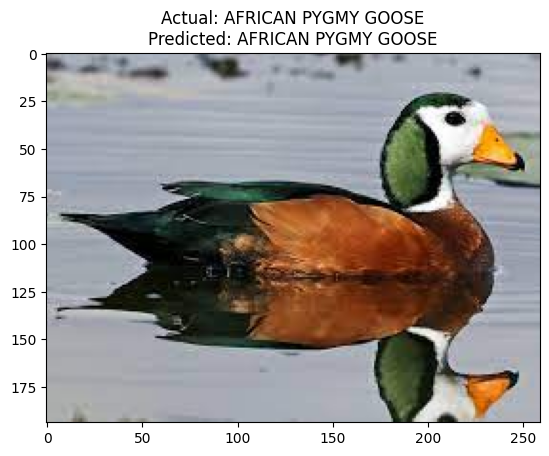

1/1 [==============================] - 0s 111ms/step


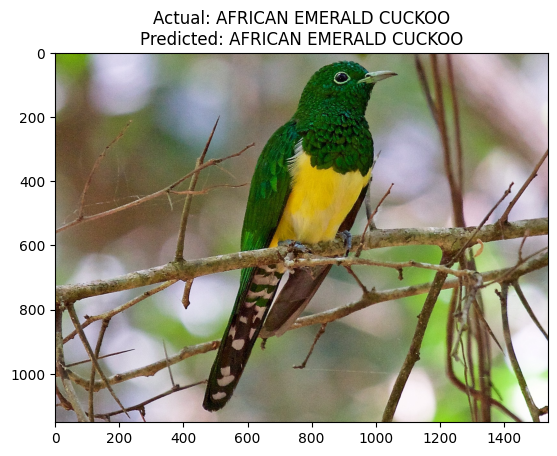

1/1 [==============================] - 0s 155ms/step


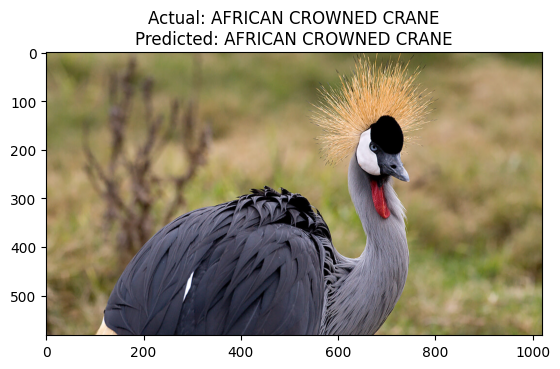

1/1 [==============================] - 0s 137ms/step


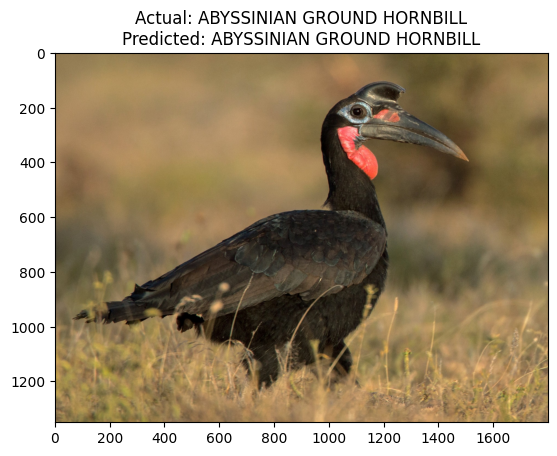

1/1 [==============================] - 0s 113ms/step


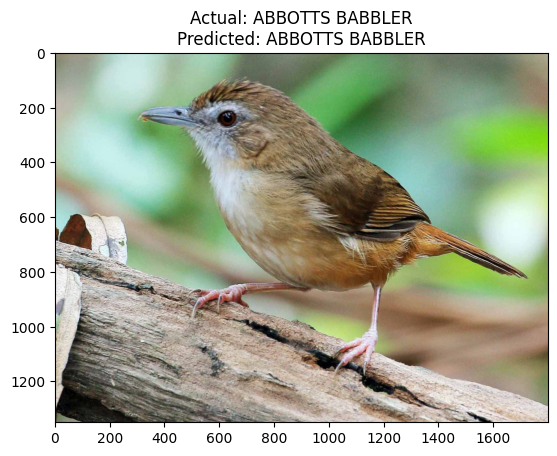

1/1 [==============================] - 0s 146ms/step


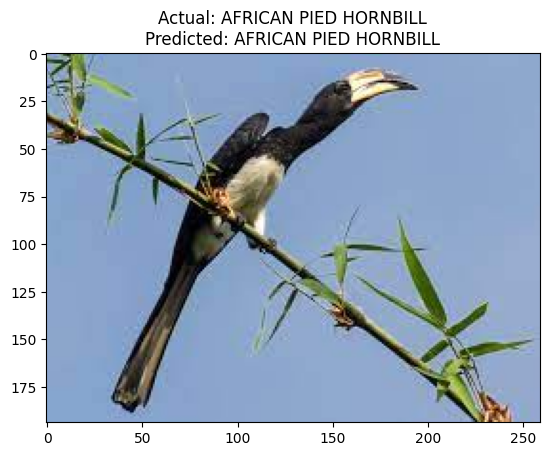

1/1 [==============================] - 0s 74ms/step


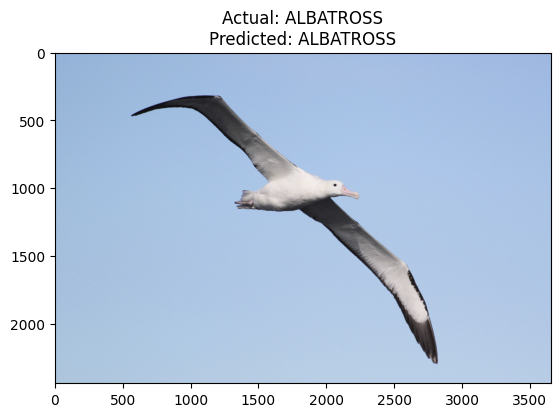

1/1 [==============================] - 0s 75ms/step


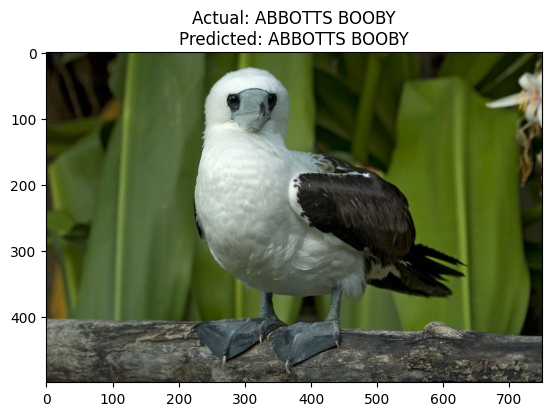

1/1 [==============================] - 0s 95ms/step


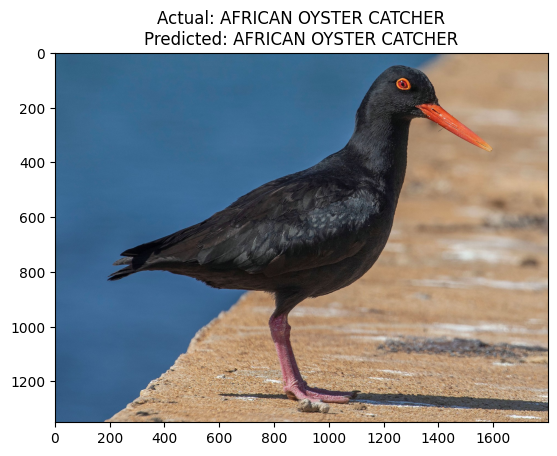

Image: drive/MyDrive/Colab Notebooks/AFRICAN FIREFINCH.jpg, Actual Class: AFRICAN FIREFINCH, Predicted Class: AFRICAN FIREFINCH
Image: drive/MyDrive/Colab Notebooks/AFRICAN PYGMY GOOSE.jpg, Actual Class: AFRICAN PYGMY GOOSE, Predicted Class: AFRICAN PYGMY GOOSE
Image: drive/MyDrive/Colab Notebooks/AFRICAN EMERALD CUCKOO.jpg, Actual Class: AFRICAN EMERALD CUCKOO, Predicted Class: AFRICAN EMERALD CUCKOO
Image: drive/MyDrive/Colab Notebooks/AFRICAN CROWNED CRANE.jpg, Actual Class: AFRICAN CROWNED CRANE, Predicted Class: AFRICAN CROWNED CRANE
Image: drive/MyDrive/Colab Notebooks/ABYSSINIAN GROUND HORNBILL.jpg, Actual Class: ABYSSINIAN GROUND HORNBILL, Predicted Class: ABYSSINIAN GROUND HORNBILL
Image: drive/MyDrive/Colab Notebooks/ABBOTTS BABBLER.jpg, Actual Class: ABBOTTS BABBLER, Predicted Class: ABBOTTS BABBLER
Image: drive/MyDrive/Colab Notebooks/AFRICAN PIED HORNBILL.jpg, Actual Class: AFRICAN PIED HORNBILL, Predicted Class: AFRICAN PIED HORNBILL
Image: drive/MyDrive/Colab Notebooks/A

In [24]:
# Example usage:
test_image_paths = ['drive/MyDrive/Colab Notebooks/AFRICAN FIREFINCH.jpg',
                    'drive/MyDrive/Colab Notebooks/AFRICAN PYGMY GOOSE.jpg',
                    'drive/MyDrive/Colab Notebooks/AFRICAN EMERALD CUCKOO.jpg',
                    'drive/MyDrive/Colab Notebooks/AFRICAN CROWNED CRANE.jpg',
                    'drive/MyDrive/Colab Notebooks/ABYSSINIAN GROUND HORNBILL.jpg',
                    'drive/MyDrive/Colab Notebooks/ABBOTTS BABBLER.jpg',
                    'drive/MyDrive/Colab Notebooks/AFRICAN PIED HORNBILL.jpg',
                    'drive/MyDrive/Colab Notebooks/ALBATROSS.jpg',
                    'drive/MyDrive/Colab Notebooks/ABBOTTS BOOBY.jpg',
                    'drive/MyDrive/Colab Notebooks/AFRICAN OYSTER CATCHER.jpg']
actual_classes = ['AFRICAN FIREFINCH', 'AFRICAN PYGMY GOOSE',
                  'AFRICAN EMERALD CUCKOO', 'AFRICAN CROWNED CRANE',
                  'ABYSSINIAN GROUND HORNBILL', 'ABBOTTS BABBLER', 'AFRICAN PIED HORNBILL',
                  'ALBATROSS', 'ABBOTTS BOOBY', 'AFRICAN OYSTER CATCHER']

predictions = visualize_predictions(model, class_indices, test_image_paths, actual_classes)

# Print the predictions
for actual_class, prediction, image_path in zip(actual_classes, predictions, test_image_paths):
    print(f'Image: {image_path}, Actual Class: {actual_class}, Predicted Class: {prediction}')